loop de treinamento basico definido abaixo

In [2]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import random
from torch import nn
import numpy as np

# faz operacoes necessarias sobre imagem: 
# transforma de pil para torch
# float32
# redimensiona para 1 x N_linhas x N_colunas
# deixa distribuicao normal com media 0 e std 1
def transform(img, mean=33., std=76.5):

    img = np.array(img, dtype=np.float32)
    img = torch.from_numpy(img)
    img = (img - mean)/std
    img = img.reshape(1, img.shape[0], img.shape[1])

    return img

# classe usada para obter amostras de datasets e usar elas como datasets
class Subset(Dataset):

    def __init__(self, data, indexs, transform=None) -> None:
        self.data = data
        self.indexs = indexs
        self.transform = transform

    def __getitem__(self, index) -> torch.float32:
        img, target = self.data[self.indexs[index]]

        if (self.transform is not None):
            img = self.transform(img)
        
        return img, target
    
    def __len__(self):
        return len(self.indexs)


# carrega dataset mnist do torchvision e gera amostras de treino e de validacao com tamanho n
def load_mnist(n=1000):

    dataset = datasets.MNIST('../data', train=True, download=True)
    random.seed(42)
    # obtem amostra de 2000 valores de 0 ate len(dataset)
    indexs_random  = random.sample(range(len(dataset)), k=2*n)
    # pega metade para treino
    dataset_train = Subset(dataset, indexs=indexs_random[n:], transform=transform)
    # outra metada para validacao
    dataset_valid = Subset(dataset, indexs=indexs_random[:n], transform=transform)

    return dataset_train, dataset_valid


In [3]:
import matplotlib.pyplot as plt
from IPython import display

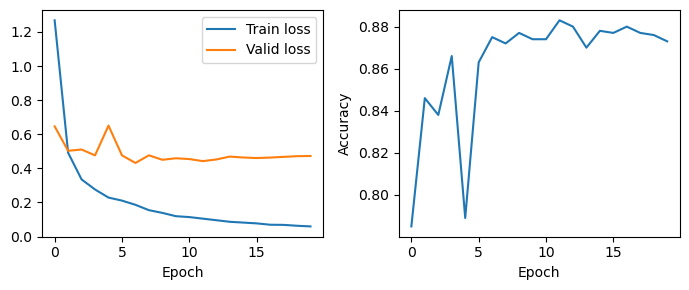

torch.Size([10, 784])


In [18]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(in_features=784, out_features=10)

    def forward(self, x):
        # transforma de bs x 1 x 28 x 28 para matriz bs x 784
        x = x.reshape(x.shape[0], -1)
        return self.layer(x)


# recebe batch de imagens e passa por cada imagem calculando scores e loss e treinando modelo com base nisso
def train_step(model, data_train_dl, optim, loss_func):

    model.train()
    loss_mean = 0.
    # percorre cada batch (bs imagens, bs targets)
    for imgs, targets in data_train_dl:
        optim.zero_grad() # zera grad dos parametros para evitar acumulo de gradientes
        scores = model(imgs) # modelo deve estar pronto para receber bs imagens ao inves de uma unica imagem por vez
        loss = loss_func(scores, targets) # scores tem formato 16x10 e targets array de 16 valores
        loss.backward()
        optim.step() # faz passo no modelo

        # serve para ponderar loss em relacao ao tamanho do batch atual pois ultimo batch pode ter tamanho 
        # diferente
        loss_mean += loss.detach()*imgs.shape[0] 
    
    # retorna media de losses considerando todas batchs usados no treinamento
    loss_mean /= len(data_train_dl.dataset)
    return loss_mean.item()

# roda batchs da amostra de validacao para obter losses e funcao de performance
@torch.no_grad()
def valid_step(model, data_valid, perf_func, loss_func):
    model.eval()
        
    loss_mean = 0.
    perf_mean = 0.
    for imgs, targets in data_valid:
        scores = model(imgs)
        loss = loss_func(scores, targets)
        perf = perf_func(scores, targets) 
        loss_mean += loss.detach()*imgs.shape[0]
        perf_mean += perf.detach()*imgs.shape[0]

    perf_mean = perf_mean/len(data_valid.dataset)
    loss_mean = loss_mean/len(data_valid.dataset)
    return perf_mean.item(), loss_mean.item()

def accuracy(scores, targets):
    # indice indica qual a predicao do digito de acordo com sua maxima probabilidade
    # indices   0         1        2             9
    # img0: prob_ser0 prob_ser1 prob_ser2 ... prob_ser9 -> argmax retorna indice e portanto predicao de target
    # preds = scores.argmax(dim=1) 
    # return (preds==targets).float().mean()
    return (scores.argmax(dim=1)==targets).float().mean()

def log_view(logger):

    epochs, losses_train, accs, losses_valid = zip(*logger)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))
    ax1.plot(epochs, losses_train, label='Train loss')
    ax1.plot(epochs, losses_valid, label='Valid loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax2.plot(epochs, accs)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    fig.tight_layout()

    display.clear_output(wait=True) 
    plt.show()

# bs eh batch_size que determina quantas imagens terao cada batch (pacote)
def train(model, data_train, data_valid, bs, lr, num_epochs, perf_func):

    # iterador de batches
    data_train_dl = DataLoader(data_train, batch_size=bs, shuffle=True)
    data_valid_dl = DataLoader(data_valid, batch_size=bs, shuffle=False)
    logger = []
    loss_func = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    for i in range(num_epochs):
        loss_train = train_step(model=model, data_train_dl=data_train_dl, optim=optim, loss_func=loss_func)
        perf, loss_valid = valid_step(model, data_valid_dl, perf_func = perf_func, loss_func=loss_func)
        logger.append((i, loss_train, perf, loss_valid))
        log_view(logger)

    return logger


model = Model()


# obtem amostras dos dados mnists (por default 1000 de treino e 1000 de validacao)
data_train, data_valid = load_mnist()


logger = train(model, data_train, data_valid, bs=64, lr=0.1, num_epochs=20, perf_func=accuracy)

Interpretação dos pesos da matriz w

In [19]:
# cada peso wij do vetor de parametros w[10x784] pode ser considerado o peso wixy (j=xy) que o modelo deu para a contribuicao do pixel xy para que a 
# imagem seja da classe i 
print(model.layer.weight.shape)

torch.Size([10, 784])


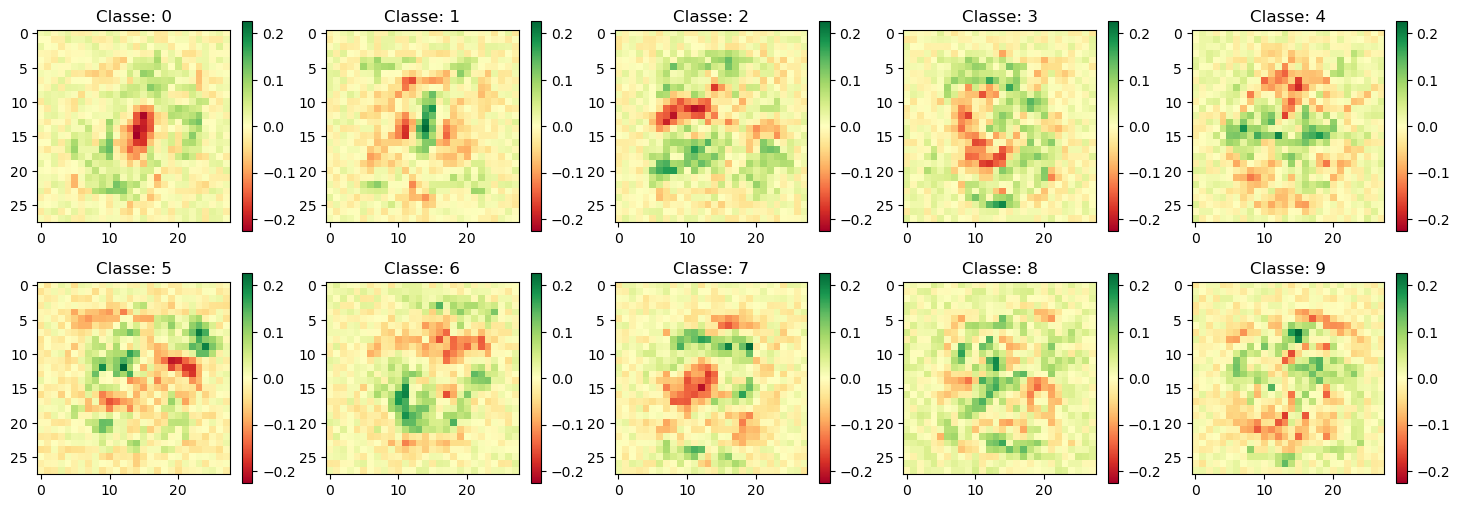

In [20]:
# grafico que mapeia valores de forma que o zero seja o centro do mapa de cores
cn = plt.matplotlib.colors.CenteredNorm()

fig, axs = plt.subplots(2, 5, figsize=(18, 6))
axs = axs.reshape(-1)

# dado a matriz de parametros w de formato 10x784 (10x28x28), a linha 0 indica qual o peso de um pixel para determinar se uma imagem pertence a classe 0
# pesos positivos indicam que determinada posicao eh importante para classificacao da imagem como sendo da classe i
# pesos negativos indicam o contrario
# na classe 0, posicoes centrais de pixeis tem pesos negativos, de forma a contribuirem para nao serem classificados como 0
# na classe 1, posicoes centrais de pixeis tem pesos positivos, de forma a contribuitem para     serem classificados como 1
for i, ax in enumerate(axs):
    weight = model.layer.weight[i].detach().reshape(28, 28)
    plot = ax.imshow(weight, 'RdYlGn', norm=cn)
    ax.set_title(f'Classe: {i}')
    fig.colorbar(plot, ax=ax)
